### 나이브 베이즈 분류기

확률 기반 분류기  
데이터가 각 클래스에 속할 특징 확률을 계산  
나이브 : 특징 간 상호 독립적이라는 가정하게 확률 계산을 단순화  
베이즈 : 입력 특징이 클래스 전체의 확률 분포 대비 특정 클래스에 속할 확률을 베이즈 정리 기반으로 계산

#### 특징 벡터 x가 주어졌을 때, k개의 클래스 중 하나에 속할 확률을 결정

In [4]:
import glob
import os
import numpy as np

In [5]:
emails, labels = [], []
paths = ['enron1/spam/','enron1/ham/']
for path in paths:
    for filename in glob.glob(os.path.join(path, "*.txt")):
        with open(filename, 'r', encoding= "ISO-8859-1") as file:
            emails.append(file.read())
            if path.endswith('spam/'):
                labels.append(1)
            else:
                labels.append(0)

In [6]:
print(np.unique(labels, return_counts=True))

(array([0, 1]), array([3672, 1500], dtype=int64))


In [7]:
import nltk
nltk.download('names')
nltk.download('wordnet')

[nltk_data] Downloading package names to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
from nltk.corpus import names
from nltk.stem import WordNetLemmatizer

In [9]:
all_names = set(names.words())
lemmatizer = WordNetLemmatizer()

In [10]:
cleaned_emails = []
for email in emails:
    cleaned_emails.append(" ".join([lemmatizer.lemmatize(word.lower()) for word in email.split() if word.isalpha() and word not in all_names]))

cleaned_emails[0]
    

'dobmeos with hgh my energy level ha gone up stukm introducing doctor formulated hgh human growth hormone also called hgh is referred to in medical science a the master hormone it is very plentiful when we are young but near the age of twenty one our body begin to produce le of it by the time we are forty nearly everyone is deficient in hgh and at eighty our production ha normally diminished at least advantage of hgh increased muscle strength loss in body fat increased bone density lower blood pressure quickens wound healing reduces cellulite improved vision wrinkle disappearance increased skin thickness texture increased energy level improved sleep and emotional stability improved memory and mental alertness increased sexual potency resistance to common illness strengthened heart muscle controlled cholesterol controlled mood swing new hair growth and color restore read more at this website unsubscribe'

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words="english", max_features=500)
term_docs = vectorizer.fit_transform(cleaned_emails)

In [12]:
print(term_docs[0])

  (0, 125)	2
  (0, 178)	2
  (0, 47)	1
  (0, 497)	1
  (0, 231)	1
  (0, 445)	1
  (0, 345)	1
  (0, 250)	1
  (0, 424)	1
  (0, 285)	1
  (0, 69)	1
  (0, 357)	1
  (0, 481)	1


In [13]:
term_docs.toarray()

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [14]:
feature_names = vectorizer.get_feature_names()
len(feature_names)

500

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleaned_emails, labels, test_size=0.3, random_state=35)
len(X_train), len(y_train), len(X_test), len(y_test)

(3620, 3620, 1552, 1552)

In [16]:
term_docs_train = vectorizer.fit_transform(X_train)
term_docs_test = vectorizer.transform(X_test)


In [17]:
from sklearn.naive_bayes import MultinomialNB

In [18]:
naive_bayes = MultinomialNB(alpha=1, fit_prior=True)
naive_bayes.fit(term_docs_train, y_train)

MultinomialNB(alpha=1)

In [19]:
y_pred = naive_bayes.predict(term_docs_test)
y_pred[:5]

array([0, 0, 0, 1, 0])

In [20]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([1060,  492], dtype=int64))

In [21]:
naive_bayes.score(term_docs_test, y_test)

0.9117268041237113

In [22]:
y_pred_proba = naive_bayes.predict_proba(term_docs_test)
y_pred_proba[:5]

array([[1.00000000e+000, 6.08798181e-313],
       [9.27911745e-001, 7.20882550e-002],
       [1.00000000e+000, 1.37875622e-037],
       [2.55081896e-013, 1.00000000e+000],
       [1.00000000e+000, 0.00000000e+000]])

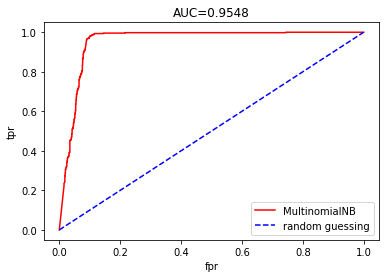

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ =roc_curve(y_test, y_pred_proba[:, 1])
auc = roc_auc_score(y_test, y_pred_proba[:, 1])
plt.plot(fpr, tpr, "r-", label="MultinomialNB")
plt.plot([0, 1], [0, 1], "b--", label="random guessing")
plt.title("AUC={:.4f}".format(auc))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
parameters = {
    "alpha": [0.5, 1.0, 1.5, 2.0],
    "fit_prior": [True, False]
}

In [26]:
grid_search = GridSearchCV(naive_bayes, parameters, n_jobs=-1, cv=10, scoring="roc_auc")

In [27]:
grid_search.fit(term_docs_train, y_train)

GridSearchCV(cv=10, estimator=MultinomialNB(alpha=1), n_jobs=-1,
             param_grid={'alpha': [0.5, 1.0, 1.5, 2.0],
                         'fit_prior': [True, False]},
             scoring='roc_auc')

In [28]:
grid_search.best_params_

{'alpha': 0.5, 'fit_prior': True}

In [32]:
naive_bayes_best = grid_search.best_estimator_

In [33]:
y_pred = naive_bayes.predict(term_docs_test)
y_pred

array([0, 0, 0, ..., 0, 0, 1])

In [34]:
naive_bayes_best.score(term_docs_test, y_pred)

0.9987113402061856

In [35]:
y_pred_proba = naive_bayes_best.predict_proba(term_docs_test)
y_pred_proba

array([[1.00000000e+00, 0.00000000e+00],
       [9.33961024e-01, 6.60389764e-02],
       [1.00000000e+00, 2.47667385e-39],
       ...,
       [1.00000000e+00, 8.77622637e-14],
       [9.98417717e-01, 1.58228326e-03],
       [3.28027188e-07, 9.99999672e-01]])

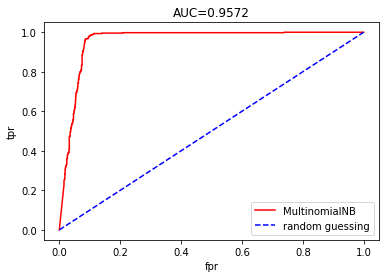

In [36]:
fpr, tpr, _ =roc_curve(y_test, y_pred_proba[:, 1])
auc = roc_auc_score(y_test, y_pred_proba[:, 1])
plt.plot(fpr, tpr, "r-", label="MultinomialNB")
plt.plot([0, 1], [0, 1], "b--", label="random guessing")
plt.title("AUC={:.4f}".format(auc))
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.legend()
